<a href="https://colab.research.google.com/github/koushikgptREAL/Natural_Language_Processing/blob/main/2203A51349_NLP_Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)


        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def train_vae(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)


        reconstruction_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        loss = reconstruction_loss + kl_divergence
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_gan(generator, discriminator, device, train_loader, g_optimizer, d_optimizer, epoch):
    generator.train()
    discriminator.train()

    for batch_idx, (real_data, _) in enumerate(train_loader):
        batch_size = real_data.size(0)
        real_data = real_data.view(-1, 784).to(device)


        d_optimizer.zero_grad()
        label_real = torch.ones(batch_size, 1).to(device)
        label_fake = torch.zeros(batch_size, 1).to(device)

        output_real = discriminator(real_data)
        d_loss_real = F.binary_cross_entropy(output_real, label_real)

        noise = torch.randn(batch_size, 100).to(device)
        fake_data = generator(noise)
        output_fake = discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(output_fake, label_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()


        g_optimizer.zero_grad()
        output_fake = discriminator(fake_data)
        g_loss = F.binary_cross_entropy(output_fake, label_real)
        g_loss.backward()
        g_optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(real_data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'D_loss: {d_loss.item():.6f}\tG_loss: {g_loss.item():.6f}')


In [4]:
def visualize_latent_space(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        test_data, test_labels = next(iter(test_loader))
        test_data = test_data.to(device)
        mu, _ = model.encode(test_data.view(-1, 784))
        z = mu.cpu().numpy()

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=test_labels, cmap='tab10')
        plt.colorbar(scatter)
        plt.title('VAE Latent Space')
        plt.xlabel('First Latent Dimension')
        plt.ylabel('Second Latent Dimension')
        plt.show()

def visualize_generated_images(model, device, is_vae=True, num_images=10):
    model.eval()
    with torch.no_grad():
        if is_vae:

            sample = torch.randn(num_images, 2).to(device)
            sample = model.decode(sample).cpu()
        else:

            sample = torch.randn(num_images, 100).to(device)
            sample = model(sample).cpu()

        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        for i, ax in enumerate(axes):
            ax.imshow(sample[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 32.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.46MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training VAE...
Train Epoch: 1 [0/60000 (0%)]	Loss: 544.554382
Train Epoch: 1 [12800/60000 (21%)]	Loss: 183.218369
Train Epoch: 1 [25600/60000 (43%)]	Loss: 178.179382
Train Epoch: 1 [38400/60000 (64%)]	Loss: 172.541626
Train Epoch: 1 [51200/60000 (85%)]	Loss: 166.925446
Train Epoch: 2 [0/60000 (0%)]	Loss: 162.408066
Train Epoch: 2 [12800/60000 (21%)]	Loss: 158.827225
Train Epoch: 2 [25600/60000 (43%)]	Loss: 154.641388
Train Epoch: 2 [38400/60000 (64%)]	Loss: 155.007477
Train Epoch: 2 [51200/60000 (85%)]	Loss: 154.002579
Train Epoch: 3 [0/60000 (0%)]	Loss: 155.649658
Train Epoch: 3 [12800/60000 (21%)]	Loss: 153.902542
Train Epoch: 3 [25600/60000 (43%)]	Loss: 161.399872
Train Epoch: 3 [38400/60000 (64%)]	Loss: 150.142563
Train Epoch: 3 [51200/60000 (85%)]	Loss: 151.914490
Train Epoch: 4 [0/60000 (0%)]	Loss: 151.137726
Train Epoch: 4 [12800/60000 (21%)]	Loss: 148.907852
Train Epoch: 4 [25600/60000 (43%)]	Loss: 141.

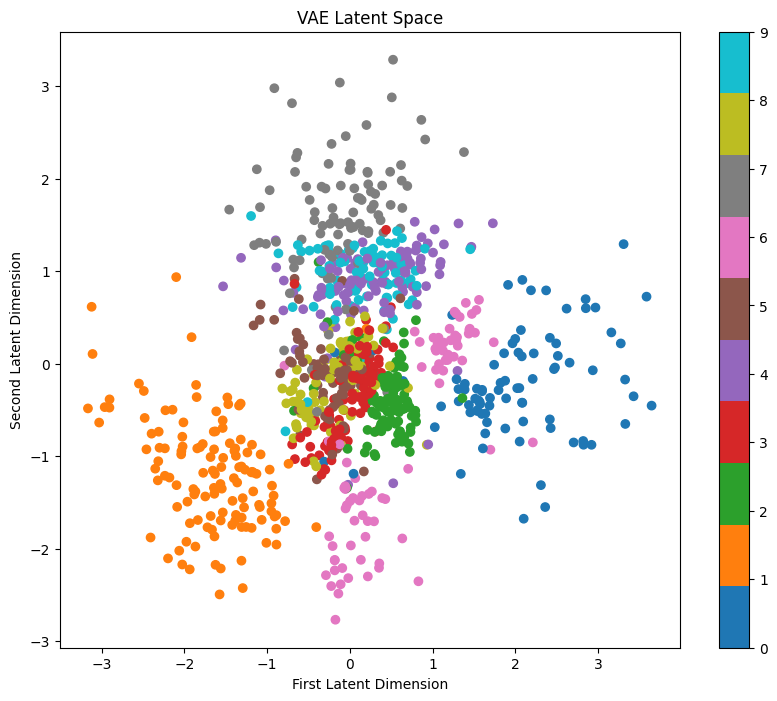


VAE generated images:


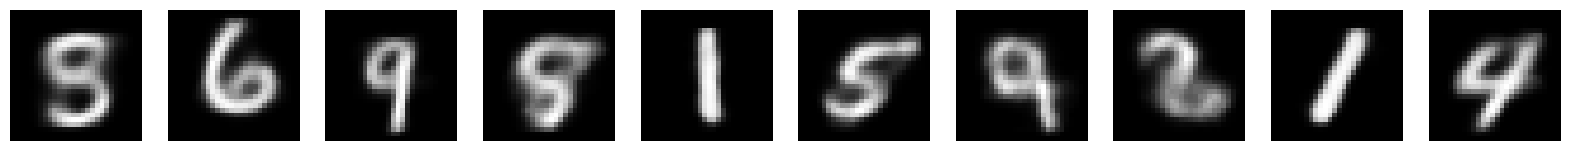


GAN generated images:


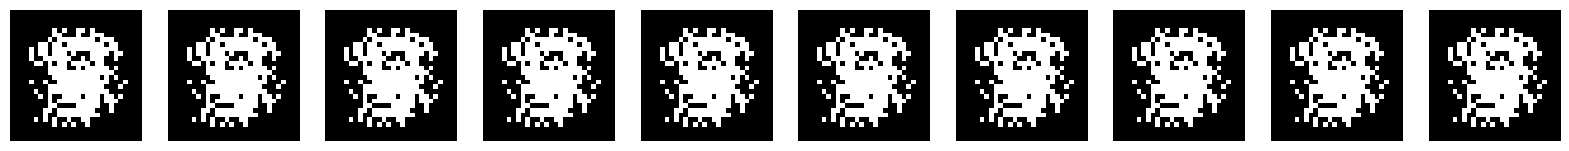

In [5]:
def main():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([transforms.ToTensor()])


    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=1000)

    vae = VAE().to(device)
    vae_optimizer = optim.Adam(vae.parameters())
    print("Training VAE...")
    for epoch in range(1, 11):
        train_vae(vae, device, train_loader, vae_optimizer, epoch)

    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    g_optimizer = optim.Adam(generator.parameters())
    d_optimizer = optim.Adam(discriminator.parameters())
    print("\nTraining GAN...")
    for epoch in range(1, 11):
        train_gan(generator, discriminator, device, train_loader, g_optimizer, d_optimizer, epoch)

    print("\nGenerating visualizations...")
    visualize_latent_space(vae, test_loader, device)
    print("\nVAE generated images:")
    visualize_generated_images(vae, device, is_vae=True)
    print("\nGAN generated images:")
    visualize_generated_images(generator, device, is_vae=False)
if __name__ == "__main__":
    main()